# OSMnx features demo

Author: [Geoff Boeing](https://geoffboeing.com/)

Get street networks and other spatial data anywhere in the world from OpenStreetMap then analyze and visualize them.

More info:

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  
This notebook provides a quick tour of some of OSMnx's key features including how to:

  - download/model street networks
  - calculate stats
  - visualize centrality
  - impute speeds/travel times and calculate shortest paths
  - attach and visualize elevation data and edge grades
  - download/model other infrastructure types
  - download points of interest data

In [14]:
import networkx as nx
import osmnx as ox

ox.__version__

'1.9.2'

## Working with street networks

In [ ]:
import osmnx as ox
import signal

# Set the timeout value (in seconds)
timeout_value = 60  # for example, set the timeout to 60 seconds

# Define a function to handle the timeout
def handle_timeout(signum, frame):
    raise TimeoutError("Request timed out")

# Set up a signal handler for SIGALRM (alarm signal)
signal.signal(signal.SIGALRM, handle_timeout)

# Download/model a street network for Piedmont, California, USA and visualize it
try:
    # Set an alarm signal to trigger after the specified timeout
    signal.alarm(timeout_value)
    
    # Attempt to download and visualize the street network
    G = ox.graph_from_place("Piedmont, California, USA", network_type="drive")
    fig, ax = ox.plot_graph(G)
    
    # Disable the alarm signal after successful completion
    signal.alarm(0)
except TimeoutError:
    print("Request timed out. Please try again later.")


/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/osmnx/_nominatim.py:65: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return _nominatim_request(params=params, request_type=request_type)
/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/osmnx/_overpass.py:350: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  overpass_settings = _make_overpass_settings()
/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/osmnx/_overpass.py:360: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/11

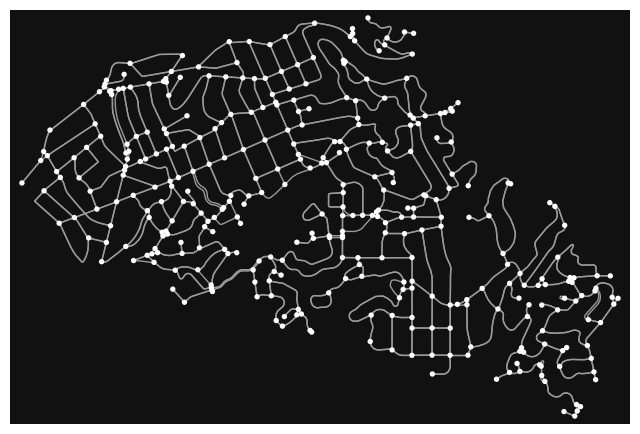

In [6]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place("Piedmont, California, USA", network_type="drive")
fig, ax = ox.plot_graph(G)

OSMnx geocodes the query "Piedmont, California, USA" to retrieve the place boundaries of that city from the Nominatim API, retrieves the drivable street network data within those boundaries from the Overpass API, constructs a graph model, then simplifies/corrects its topology such that nodes represent intersections and dead-ends and edges represent the street segments linking them. All of this is discussed in detail in the documentation and these examples.

OSMnx models all networks as NetworkX `MultiDiGraph` objects. You can convert to:
  - undirected MultiGraphs
  - DiGraphs without (possible) parallel edges
  - GeoPandas node/edge GeoDataFrames

In [5]:
# convert your MultiDiGraph to an undirected MultiGraph
M = ox.convert.to_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges
D = ox.convert.to_digraph(G)

In [7]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
53017091,37.826250,-122.247604,3,NaN,POINT (-122.24760 37.82625)
53018397,37.824224,-122.247194,3,NaN,POINT (-122.24719 37.82422)
53018399,37.824900,-122.246113,3,NaN,POINT (-122.24611 37.82490)
53018402,37.825406,-122.245338,3,NaN,POINT (-122.24534 37.82541)
53018404,37.825948,-122.244467,3,NaN,POINT (-122.24447 37.82595)


In [8]:
gdf_edges.head()

osmid          name      highway  oneway reversed  \
u        v        key                                                          
53017091 53064327 0      6345781   Rose Avenue  residential   False    False   
         53075599 0      6345781   Rose Avenue  residential   False     True   
53018397 53018399 0      6327298   Lake Avenue  residential   False    False   
         53018411 0    196739937  Linda Avenue     tertiary   False    False   
         53097980 0    196739937  Linda Avenue     tertiary   False     True   

                        length  \
u        v        key            
53017091 53064327 0    230.124   
         53075599 0    122.235   
53018397 53018399 0    121.096   
         53018411 0     37.803   
         53097980 0     99.976   

                                                                geometry  \
u        v        key                                                      
53017091 53064327 0    LINESTRING (-122.24760 37.82625, -122.24750 37...   
         53075599 0    LINESTRING (-122.24760 37.82625, -122.24771 37...   
53018397 53018399 0    LINESTRING (-122.24719 37.82422, -122.24712 37...   
         53018411 0    LINESTRING (-122.24719 37.82422, -122.24713 37...   
         53097980 0    LINESTRING (-122.24719 37.82422, -122.24773 37...   

                      lanes maxspeed bridge junction  
u        v        key                                 
53017091 53064327 0     NaN      NaN    NaN      NaN  
         53075599 0     NaN      NaN    NaN      NaN  
53018397 53018399 0     NaN      NaN    NaN      NaN  
         53018411 0     NaN      NaN    NaN      NaN  
         53097980 0     NaN      NaN    NaN      NaN

You can create a graph from node/edge GeoDataFrames, as long as gdf_nodes is indexed by osmid and gdf_edges is multi-indexed by u, v, key (following normal MultiDiGraph structure). This allows you to load graph node/edge ShapeFiles or GeoPackage layers as GeoDataFrames then convert to a MultiDiGraph for graph analytics.

In [9]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G2 = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

## Basic street network stats

In [10]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

4199283.565369835

In [11]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 352,
 'm': 944,
 'k_avg': 5.363636363636363,
 'edge_length_total': 112028.74700000025,
 'edge_length_avg': 118.67452012711891,
 'streets_per_node_avg': 2.9488636363636362,
 'streets_per_node_counts': {0: 0, 1: 34, 2: 0, 3: 270, 4: 46, 5: 2},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.09659090909090909,
  2: 0.0,
  3: 0.7670454545454546,
  4: 0.13068181818181818,
  5: 0.005681818181818182},
 'intersection_count': 318,
 'street_length_total': 58076.215999999986,
 'street_segment_count': 495,
 'street_length_avg': 117.32568888888886,
 'circuity_avg': 1.1111616427989621,
 'self_loop_proportion': 0.006060606060606061,
 'clean_intersection_count': 267,
 'node_density_km': 83.82382244981807,
 'intersection_density_km': 75.72720323591518,
 'edge_density_km': 26678.061925578433,
 'street_density_km': 13830.029598128642,
 'clean_intersection_density_km': 63.58227441506086}

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [12]:
# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
ox.save_graph_geopackage(G, filepath="./data/mynetwork.gpkg")
ox.save_graphml(G, filepath="./data/mynetwork.graphml")

## Visualize street centrality

Here we plot the street network and color its edges (streets) by their relative closeness centrality.

In [15]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

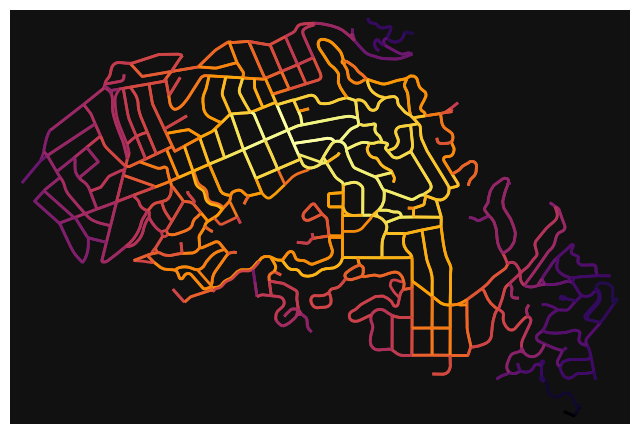

In [16]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

## Routing

In [17]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.routing.add_edge_speeds(G)
G = ox.routing.add_edge_travel_times(G)

In [18]:
# get the nearest network nodes to two lat/lng points with the distance module
orig = ox.distance.nearest_nodes(G, X=-122.245846, Y=37.828903)
dest = ox.distance.nearest_nodes(G, X=-122.215006, Y=37.812303)

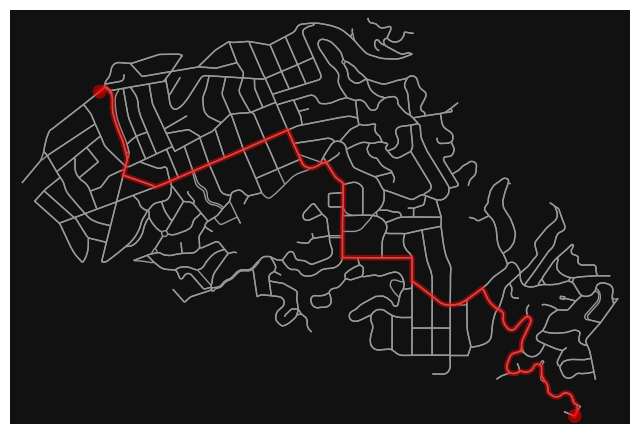

In [19]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [20]:
# how long is our route in meters?
edge_lengths = ox.routing.route_to_gdf(G, route)["length"]
round(sum(edge_lengths))

4761

In [21]:
# how far is it between these two nodes as the crow flies?
# use OSMnx's vectorized great-circle distance (haversine) function
orig_x = G.nodes[orig]["x"]
orig_y = G.nodes[orig]["y"]
dest_x = G.nodes[dest]["x"]
dest_y = G.nodes[dest]["y"]
round(ox.distance.great_circle(orig_y, orig_x, dest_y, dest_x))

3124

You can add elevation attributes to your graph's nodes automatically with the `elevation` module, using either local raster files or the Google Maps Elevation API.

In [22]:
# add elevation to nodes automatically, calculate edge grades, plot network
# you need a google elevation api key to run this cell!
try:
    from keys import google_elevation_api_key

    G = ox.elevation.add_node_elevations_google(G, api_key=google_elevation_api_key)
    G = ox.elevation.add_edge_grades(G)
    nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
    fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, edge_linewidth=2, edge_color="#333")
except ImportError:
    print("You need a google_elevation_api_key to run this cell.")

You need a google_elevation_api_key to run this cell.


Nodes are colored from lowest elevation (dark blue) to highest (bright yellow).

Example: create [elevation-based](12-node-elevations-edge-grades.ipynb) impedance functions to route around hills.

## Get networks other ways

make queries less ambiguous to help the geocoder out, if it's not finding what you're looking for

/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/osmnx/_nominatim.py:65: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return _nominatim_request(params=params, request_type=request_type)
/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/osmnx/_overpass.py:350: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  overpass_settings = _make_overpass_settings()
/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/osmnx/_overpass.py:360: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/11

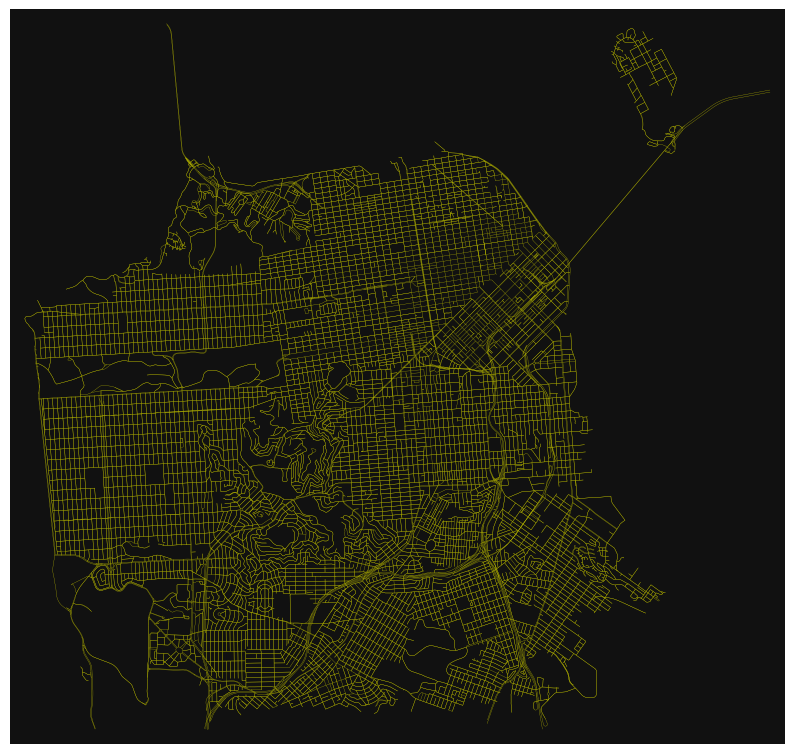

In [23]:
# you can make query an unambiguous dict to help the geocoder find it
place = {"city": "San Francisco", "state": "California", "country": "USA"}
G = ox.graph_from_place(place, network_type="drive", truncate_by_edge=True)
fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color="y", edge_linewidth=0.2)

/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/osmnx/_nominatim.py:65: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return _nominatim_request(params=params, request_type=request_type)
/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/osmnx/_overpass.py:350: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  overpass_settings = _make_overpass_settings()
/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/osmnx/_overpass.py:360: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/11

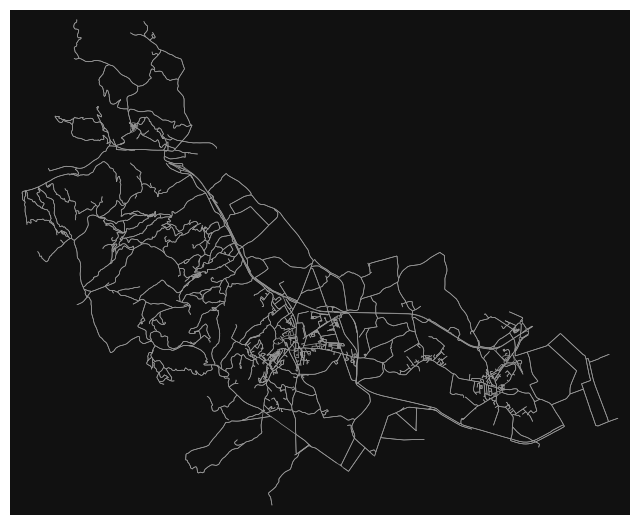

In [24]:
# you can get networks anywhere in the world
G = ox.graph_from_place("Sinalunga, Italy", network_type="all")
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5)

/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/osmnx/_overpass.py:350: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  overpass_settings = _make_overpass_settings()
/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/osmnx/_overpass.py:360: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  yield _overpass_request(data={"data": query_str})


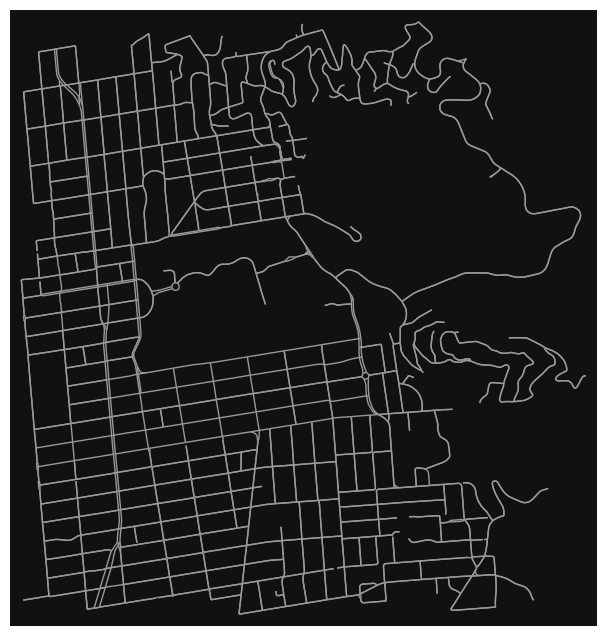

In [27]:
# or get network by address, coordinates, bounding box, or any custom polygon
# ...useful when OSM just doesn't already have a polygon for the place you want
wurster_hall = (37.870605, -122.254830)
one_mile = 1609  # meters
G = ox.graph_from_point(wurster_hall, dist=one_mile, network_type="drive")
fig, ax = ox.plot_graph(G, node_size=0)

Examples of [getting networks](01-overview-osmnx.ipynb) by coordinates, bounding box, or any custom polygon shape.

## Get other networked infrastructure types

...like rail or electric grids or even the canals of Venice and Amsterdam, using the `custom_filter` parameter: [see more examples](08-custom-filters-infrastructure.ipynb).

/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/osmnx/_nominatim.py:65: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return _nominatim_request(params=params, request_type=request_type)
/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/osmnx/_overpass.py:350: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  overpass_settings = _make_overpass_settings()
/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/osmnx/_overpass.py:360: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/11

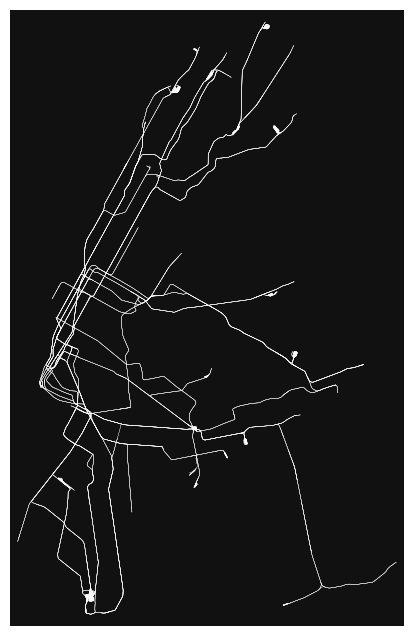

In [28]:
# get NY subway rail network
G = ox.graph_from_place(
    "New York, New York, USA",
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    custom_filter='["railway"~"subway"]',
)

fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

## Get any geospatial features' geometries and attributes

Use the `features` module to download any OSM features, such as local amenities, points of interest, or building footprints, and turn them into a GeoDataFrame: [see docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.features). For more usage examples of downloading geospatial features from OSM, see [this notebook](16-download-osm-geospatial-features.ipynb).

In [29]:
# get all building footprints in some neighborhood
place = "SoHo, New York, NY"
tags = {"building": True}
gdf = ox.features_from_place(place, tags)
gdf.shape

/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/osmnx/_nominatim.py:65: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return _nominatim_request(params=params, request_type=request_type)
/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/osmnx/_overpass.py:276: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  overpass_settings = _make_overpass_settings()
/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/osmnx/_overpass.py:386: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/11

(848, 88)

/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


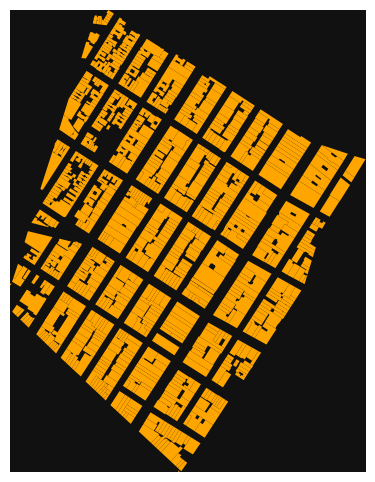

In [37]:
fig, ax = ox.plot_footprints(gdf, figsize=(18, 6))

See the other notebooks for more examples of visualization with OSMnx.

In [39]:
# get all parks and bus stops in some neighborhood
tags = {"leisure": "park", "highway": "bus_stop"}
gdf = ox.features_from_place(place, tags)
gdf.shape
gdf.head()

/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/osmnx/_nominatim.py:65: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return _nominatim_request(params=params, request_type=request_type)
/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/kogzqwerty2798/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated an

geometry  bus   highway  \
element_type osmid                                                   
node         4754117949  POINT (-74.00101 40.72058)  yes  bus_stop   
             4755831434  POINT (-73.99808 40.72401)  yes  bus_stop   
             4755831436  POINT (-73.99911 40.72276)  yes  bus_stop   
             4755831439  POINT (-74.00011 40.72165)  yes  bus_stop   
             4755898714  POINT (-73.99634 40.72518)  yes  bus_stop   

                                                   name      network  \
element_type osmid                                                     
node         4754117949         Broadway & Grand Street  NYC Transit   
             4755831434        Broadway & Prince Street          NaN   
             4755831436        Broadway & Spring Street  NYC Transit   
             4755831439        Broadway & Broome Street  NYC Transit   
             4755898714  East Houston Street & Broadway  NYC Transit   

                        network:wikidata                   network:wikipedia  \
element_type osmid                                                             
node         4754117949         Q1325591  en:New York City Transit Authority   
             4755831434              NaN                                 NaN   
             4755831436         Q1325591  en:New York City Transit Authority   
             4755831439         Q1325591  en:New York City Transit Authority   
             4755898714         Q1325591  en:New York City Transit Authority   

                                                operator public_transport  \
element_type osmid                                                          
node         4754117949  New York City Transit Authority         platform   
             4755831434  New York City Transit Authority         platform   
             4755831436  New York City Transit Authority         platform   
             4755831439  New York City Transit Authority         platform   
             4755898714  New York City Transit Authority         platform   

                            ref  ... gnis:state_id website addr:city  \
element_type osmid               ...                                   
node         4754117949  400159  ...           NaN     NaN       NaN   
             4755831434  404916  ...           NaN     NaN       NaN   
             4755831436  400157  ...           NaN     NaN       NaN   
             4755831439  405277  ...           NaN     NaN       NaN   
             4755898714  402026  ...           NaN     NaN       NaN   

                        addr:postcode addr:state opening_hours operator:short  \
element_type osmid                                                              
node         4754117949           NaN        NaN           NaN            NaN   
             4755831434           NaN        NaN           NaN            NaN   
             4755831436           NaN        NaN           NaN            NaN   
             4755831439           NaN        NaN           NaN            NaN   
             4755898714           NaN        NaN           NaN            NaN   

                        operator:type operator:wikidata addr:street  
element_type osmid                                                   
node         4754117949           NaN               NaN         NaN  
             4755831434           NaN               NaN         NaN  
             4755831436           NaN               NaN         NaN  
             4755831439           NaN               NaN         NaN  
             4755898714           NaN               NaN         NaN  

[5 rows x 36 columns]